In [157]:
import pandas as pd
from mne import create_info
from mne.io import RawArray
import  mne
import numpy as np

Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\wan_20230421\wan_20230421.fif...
    Range : 0 ... 33239 =      0.000 ...   132.956 secs
Ready.
Reading 0 ... 33239  =      0.000 ...   132.956 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 1.50 Hz
- Upper transition bandwidth: 1.50 Hz
- Filter length: 551 samples (2.204 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 77 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 

C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18108\4247913842.py:5: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\wan_20230421\wan_20230421.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname,  preload = True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent wo

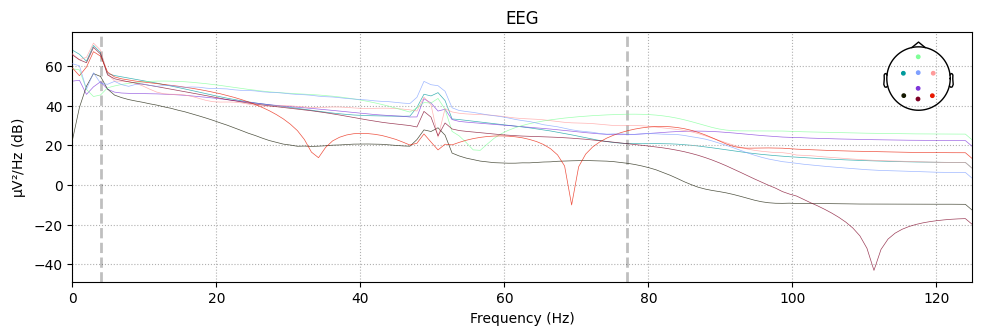

In [170]:
# fname = r"E:\Thesis\HybridSpeller\three_flicker\record\sunsun_20230420_night\sunsun_20230420_night.fif"
# fname = r"E:\Thesis\HybridSpeller\three_flicker\record\sunsun_20230419\sunsun_20230419.fif"
fname = r"E:\Thesis\HybridSpeller\three_flicker\record\wan_20230421\wan_20230421.fif"
# fname = r"E:\Thesis\HybridSpeller\three_flicker\record\anagha_20230421\anagha_20230421.fif"
raw =  mne.io.read_raw_fif(fname,  preload = True)
# new_data = raw.get_data()[:,10*250:-10*250]
# raw_new = mne.io.RawArray(new_data, raw.info)
# raw_new.notch_filter([50,100], trans_bandwidth = 3)
# raw_new.filter(4,77)
# raw_new.compute_psd().plot()
raw.notch_filter([50,100], trans_bandwidth = 3)
raw.filter(4,77)
raw.compute_psd().plot()

In [171]:
# raw = raw_new

In [172]:
events = mne.find_events(raw, initial_event = True)
tmin, tmax = 1, 5 - 1/250  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)
data = epochs.get_data() 
print(data.shape)

18 events found
Event IDs: [1 2 3]
Using data from preloaded Raw for 18 events and 1000 original time points ...
0 bad epochs dropped
(18, 9, 1000)


In [173]:
X = epochs.get_data()[:, :-1, :] * 1e-6  # micro-volt default
y = epochs.events[:, -1]

Using data from preloaded Raw for 18 events and 1000 original time points ...


In [174]:
print(X.shape)
print(y.shape)

(18, 8, 1000)
(18,)


In [175]:
y

array([1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2], dtype=int64)

In [176]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    # P = abs(P @ P.T)
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

In [177]:
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# estimator=TRCA(n_components = 1, n_jobs=-1)
# model = estimator.fit(X_train, y_train)
# preds = model.predict(X_test)
# acc = np.mean(preds == y_test)
# print(preds)
# print(y_test)
# print(acc)

In [178]:
import pickle

loaded_model = pickle.load(open(r"E:\Thesis\HybridSpeller\three_flicker\TRCA_model.sav", 'rb'))

In [179]:
preds = loaded_model.predict(X)
acc = np.mean(preds == y)
print(acc)

1.0


In [180]:
print(preds)
print(y)

[1 3 2 1 3 2 1 3 2 1 3 2 1 3 2 1 3 2]
[1 3 2 1 3 2 1 3 2 1 3 2 1 3 2 1 3 2]


In [169]:
# from sklearn.model_selection import StratifiedKFold

# estimator=TRCA(n_components = 1, n_jobs=-1)
# skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
# print(skf)
# accs = []
# for i, (train_index, test_index) in enumerate(skf.split(X, y)):
#     print(f"Fold {i}:")
#     print(f"  Train: ", y[train_index])
#     print(f"  Test: ", y[test_index])
#     # model = estimator.fit(X[train_index], y[train_index])
#     preds = loaded_model.predict(X[test_index])
#     acc = np.mean(preds == y[test_index])
#     accs.append(acc)
#     print(y[test_index])
#     print(preds)
#     print(acc)
# print("Average accuracy ==>", np.mean(accs))
